## 📓 Credit Scoring Model – Give Me Some Credit Dataset

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


# 📂 1. Load Dataset

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("saleha07/give-me-some-credit")
print("✅ Path to dataset:", path)

# Load data
df = pd.read_csv(f"{path}/cs-training.csv")
df.head()


100%|██████████| 5.16M/5.16M [00:00<00:00, 5.43MB/s]

Extracting files...


✅ Path to dataset: /root/.cache/kagglehub/datasets/saleha07/give-me-some-credit/versions/1


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Explore Dataset

Shape: (150000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non

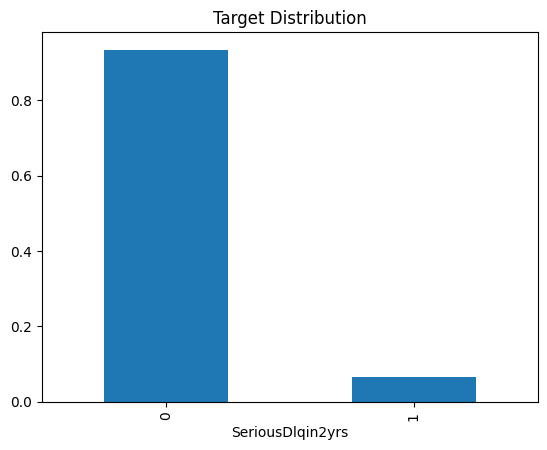

In [3]:
# Shape and info
print("Shape:", df.shape)
print(df.info())

# Target distribution
df['SeriousDlqin2yrs'].value_counts(normalize=True).plot(kind='bar', title="Target Distribution")
plt.show()


## Data Cleaning

In [4]:
# Drop ID column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Check missing values
print(df.isnull().sum())

# Impute missing values
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## Feature Engineering

In [5]:
# Create new features
df['IncomePerDependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
df['DebtToIncomeRatio'] = df['DebtRatio'] * df['MonthlyIncome']

# Cap unrealistic ages
df = df[df['age'] >= 18]


## Train-Test Split

In [6]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (119999, 12) Test size: (30000, 12)


# Baseline Models
###Logistic Regression

In [7]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

print("🔹 Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


🔹 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86     27995
           1       0.18      0.67      0.28      2005

    accuracy                           0.77     30000
   macro avg       0.57      0.72      0.57     30000
weighted avg       0.92      0.77      0.82     30000

ROC-AUC: 0.8005925799895688


# Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("🔹 Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


🔹 Random Forest Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.55      0.15      0.24      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.57      0.60     30000
weighted avg       0.92      0.94      0.92     30000

ROC-AUC: 0.8456342088162341


# 📊  ROC Curve

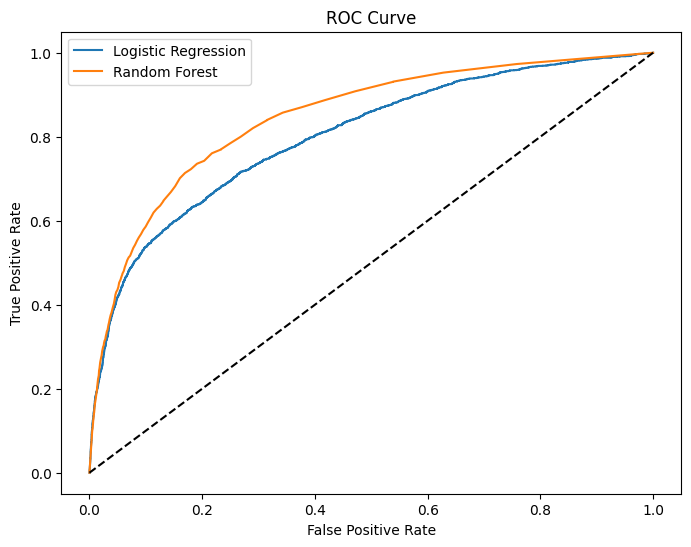

In [9]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
